<a href="https://colab.research.google.com/github/Samir-atra/Other/blob/main/Capsa_experience/Capsa_Copy_of_Train%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pathlib
import IPython
import sys
import matplotlib.pyplot as plt
!pip install keras_tuner -q
import keras_tuner
!pip install git+https://github.com/themis-ai/capsa.git
import capsa
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl
from capsa import EnsembleWrapper, DropoutWrapper, VAEWrapper
!pip install helper
import helper
from array_dataset import dataset


from google.colab import drive             
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/themis-ai/capsa.git to /tmp/pip-req-build-_mpr_llr
  Running command git clone --filter=blob:none --quiet https://github.com/themis-ai/capsa.git /tmp/pip-req-build-_mpr_llr
  Resolved https://github.com/themis-ai/capsa.git to commit d5f0decf7e8d4abdb9ca370a0b9bb03787de8e9a
  Preparing metadata (setup.py) ... done
  Created wheel for capsa: filename=capsa-0.1.5-py3-none-any.whl size=48480 sha256=7451ac33bb74d6d6a0b048708d839793ac71ca50bc6eaca93608b1fdad6d212e
  Stored in directory: /tmp/pip-ephem-wheel-cache-fza25hnu/wheels/b8/21/2a/cb813978e5d8e8ffb82950eb786e69e6b70288ebea8557ff11
Successfully built capsa
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aamini/introtodeeplearning.git (to revision 2023)

In [2]:
# Dataset loading

data_path = pathlib.Path('/content/drive/MyDrive/archiveX3/Training/')
data_path_test = pathlib.Path('/content/drive/MyDrive/archiveX3/Testing/')

dataset_path = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels= 'inferred',
    validation_split=0.2,
    subset='training',
    seed= 1,
    batch_size=64,
    image_size=(64, 64),
    color_mode="rgb")
    # shuffle=True)

dataset_path_val = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels= 'inferred',
    validation_split=0.2,
    subset='validation',
    seed= 2,
    batch_size=64,
    image_size=(64, 64),
    color_mode="rgb")
    # shuffle=True)

test_images, test_labels = dataset(data_path)

dataset_path_test = tf.keras.utils.image_dataset_from_directory(
    data_path_test,
    labels= 'inferred',
    seed= 3,
    batch_size=64,
    image_size=(64, 64),
    color_mode="rgb")
    # shuffle=True)

efficientnet_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels= 'inferred',
    seed= 3,
    batch_size=64,
    image_size=(240, 240),
    color_mode="rgb")

# efficientnet_dataset_val = tf.keras.utils.image_dataset_from_directory(
#     data_path,
#     labels= 'inferred',
#     seed= 3,
#     batch_size=64,
#     image_size=(240, 240),
#     color_mode="rgb")

num_classes = 1



Found 4159 files belonging to 2 classes.
Using 3328 files for training.
Found 4159 files belonging to 2 classes.
Using 831 files for validation.
Found 921 files belonging to 2 classes.
Found 4159 files belonging to 2 classes.


In [3]:
# Encoder, Decoder, and transfer learning base model


encoder = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, 3, strides = 2, padding = "same",  activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),                                                                         #DP1
    tf.keras.layers.Conv2D(32, 3, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),                                                                         #DP2
    tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, 1, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),                                                                         #DP3
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 512, activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),                                                                         #DP4                                                                        #DP5
    tf.keras.layers.Dense(num_classes, activation= None)
])


decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(units=4*4*128),  
        tf.keras.layers.Reshape((4, 4, 128)),
        tf.keras.layers.Conv2DTranspose(64, 1,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, 3,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(16, 3,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(3, 3,  strides=2, padding = "same"),
    ])

base_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2", trainable=False),  
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
base_model.build([None, 240, 240, 3]) 


Epoch 1/30


52/52 [==============================] - 38s 249ms/step - vae_compiled_loss: 1.1553 - vae_compiled_binary_accuracy: 0.5292 - vae_wrapper_loss: 73917360.0000 - val_vae_compiled_loss: 0.9412 - val_vae_compiled_binary_accuracy: 0.5692 - val_vae_wrapper_loss: 35802904.0000
Epoch 2/30
52/52 [==============================] - 9s 155ms/step - vae_compiled_loss: 0.9237 - vae_compiled_binary_accuracy: 0.5567 - vae_wrapper_loss: 33984568.0000 - val_vae_compiled_loss: 0.8770 - val_vae_compiled_binary_accuracy: 0.5848 - val_vae_wrapper_loss: 35323252.0000
Epoch 3/30
52/52 [==============================] - 7s 128ms/step - vae_compiled_loss: 0.7953 - vae_compiled_binary_accuracy: 0.6288 - vae_wrapper_loss: 31005264.0000 - val_vae_compiled_loss: 0.7483 - val_vae_compiled_binary_accuracy: 0.6450 - val_vae_wrapper_loss: 32189746.0000
Epoch 4/30
52/52 [==============================] - 9s 154ms/step - vae_compiled_loss: 0.7552 - vae_compiled_binary_accuracy: 0.6440 - vae_wrapper_loss: 31057544.0000 - v

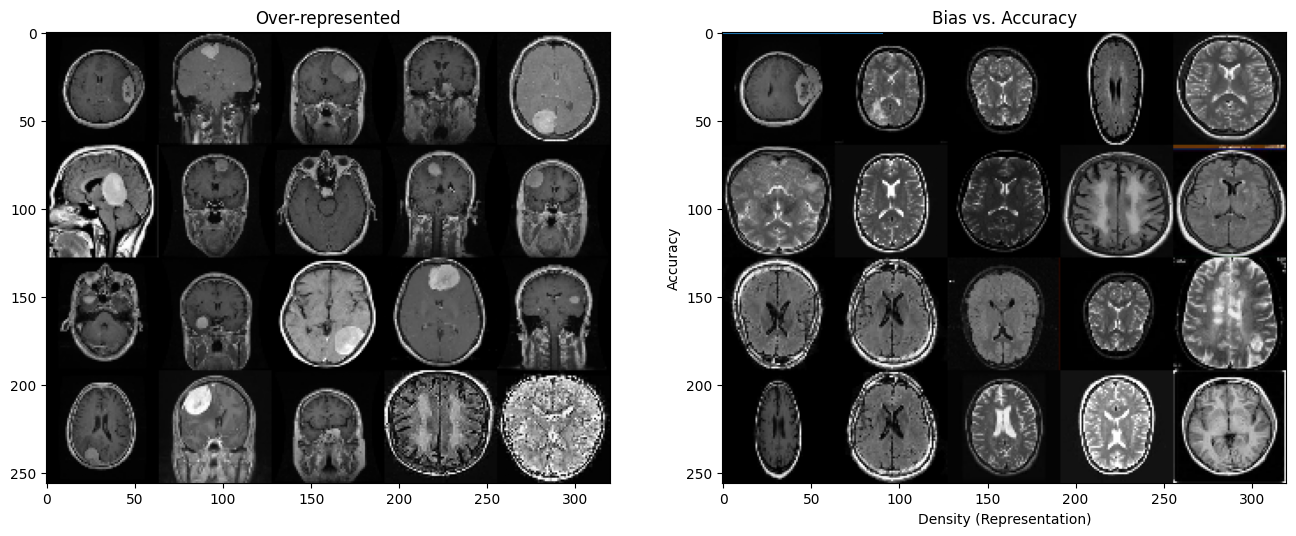

<Figure size 640x480 with 0 Axes>

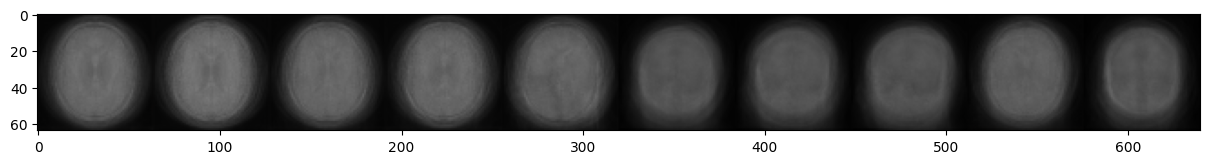

In [4]:
# HistogramVAE Wrapper

wrapped_model = capsa.HistogramVAEWrapper(encoder, num_bins=5, queue_size=20000, latent_dim = 64, decoder=decoder)

wrapped_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss= tf.losses.BinaryCrossentropy(from_logits= True),
    metrics= [tf.keras.metrics.BinaryAccuracy()]
)


history = wrapped_model.fit(
    dataset_path,
    epochs=30,                                    
    validation_data = dataset_path_val)


out = wrapped_model.predict(test_images, batch_size=512)

indices = np.argsort(out.bias, axis=None) 
sorted_images = test_images[indices]
sorted_biases = out.bias.numpy()[indices]
sorted_preds = out.y_hat.numpy()[indices]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

In [ ]:
# MVE Wrapper

mve_model = capsa.MVEWrapper(encoder, is_classification=True)
# mve_model = capsa.MVEWrapper(base_model, is_classification=True)


mve_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.BinaryAccuracy()], 
    run_eagerly=True
)

history = mve_model.fit(
        dataset_path,
        epochs=6,
        batch_size=64,
  )

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = dataset_path.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = dataset_path_test.map(lambda x, y: (normalization_layer(x), y))

images = np.vstack((normalized_test_ds, normalized_train_ds))


In [ ]:
# Ensemble Wrapper

Ensemble_wrapped_model = EnsembleWrapper(encoder, num_members=1)


Ensemble_wrapped_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
                     )

history = Ensemble_wrapped_model.fit(
        dataset_path,
        epochs=12,
        batch_size=64,
  )



In [ ]:
# Dropout Wrapper

dropout_model = DropoutWrapper(encoder, p=0.5)
# dropout_model = DropoutWrapper(base_model, p=0.5)


dropout_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
                     )

history = dropout_model.fit(
        efficientnet_dataset,
        epochs=12,
        batch_size=64,
  )

In [ ]:
# VAE Wrapper

vae_model = VAEWrapper(encoder, decoder=decoder)

vae_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0000001),
    loss= tf.losses.BinaryCrossentropy(from_logits= True),
    metrics= [tf.keras.metrics.BinaryAccuracy()]
)

history = vae_model.fit(
    dataset_path,
    epochs=3,                                    
    validation_data = dataset_path_val)

